# RQ1: Long-Term Temperature Trends by Altitude

## Initialize Spark Session

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('Climalyticsat').getOrCreate()

In [2]:
spark

## Load CSV Data

In [3]:
df_csv = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv("/home/jovyan/work/climate_all_stations.csv")

## Inspect Schema and Sample Records

In [4]:
df_csv.printSchema()
df_csv.show(5)

root
 |-- station_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- absf_max: double (nullable = true)
 |-- absf_max_flag: double (nullable = true)
 |-- absf_min: double (nullable = true)
 |-- absf_min_flag: double (nullable = true)
 |-- absf_mittel: double (nullable = true)
 |-- absf_mittel_flag: double (nullable = true)
 |-- aequi: double (nullable = true)
 |-- aequi_flag: double (nullable = true)
 |-- bet0: double (nullable = true)
 |-- bet0_flag: double (nullable = true)
 |-- bet0_max: double (nullable = true)
 |-- bet0_max_flag: double (nullable = true)
 |-- bet0_min: double (nullable = true)
 |-- bet0_min_flag: double (nullable = true)
 |-- bewm_iii_mittel: double (nullable = true)
 |-- bewm_iii_mittel_flag: double (nullable = true)
 |-- bewm_ii_mittel: double (nullable = true)
 |-- bewm_ii_mittel_flag: double (nullable = true)
 |-- bewm_i_mittel: double (nullable = true)
 |-- bewm_i_mittel_flag: double (nullable = true)
 |-- bewm_mittel: double (nullable 

## Save as Parquet Format

In [5]:
df_csv.write.mode("overwrite").parquet("/home/jovyan/work/parquet/climate_all_stations")

## Load Parquet File

In [6]:
df = spark.read.parquet("/home/jovyan/work/parquet/climate_all_stations")
df.printSchema()
df.show(5)


root
 |-- station_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- absf_max: double (nullable = true)
 |-- absf_max_flag: double (nullable = true)
 |-- absf_min: double (nullable = true)
 |-- absf_min_flag: double (nullable = true)
 |-- absf_mittel: double (nullable = true)
 |-- absf_mittel_flag: double (nullable = true)
 |-- aequi: double (nullable = true)
 |-- aequi_flag: double (nullable = true)
 |-- bet0: double (nullable = true)
 |-- bet0_flag: double (nullable = true)
 |-- bet0_max: double (nullable = true)
 |-- bet0_max_flag: double (nullable = true)
 |-- bet0_min: double (nullable = true)
 |-- bet0_min_flag: double (nullable = true)
 |-- bewm_iii_mittel: double (nullable = true)
 |-- bewm_iii_mittel_flag: double (nullable = true)
 |-- bewm_ii_mittel: double (nullable = true)
 |-- bewm_ii_mittel_flag: double (nullable = true)
 |-- bewm_i_mittel: double (nullable = true)
 |-- bewm_i_mittel_flag: double (nullable = true)
 |-- bewm_mittel: double (nullable 

## Load Station Metadata

In [7]:
stations_meta = spark.read.option("header", True).option("inferSchema", True).csv("/home/jovyan/work/stations_metadata.csv")

# Rename columns for join compatibility
stations_meta = stations_meta.withColumnRenamed("id", "station_id") \
                             .withColumnRenamed("Höhe [m]", "altitude")

stations_meta.select("station_id", "altitude").show(5)



+----------+--------+
|station_id|altitude|
+----------+--------+
|         1|   783.2|
|         2|   641.0|
|         3|   598.8|
|         4|   266.0|
|         5|   743.1|
+----------+--------+
only showing top 5 rows



## Join Climate Data with Altitude Metadata

In [8]:
# Nur relevante Spalten
df = df.select("station_id", "date", "tl_mittel")

# Join mit Höhenmetadaten
df_joined = df.join(stations_meta, on="station_id")

# Kurzer Check
df_joined.select("station_id", "date", "tl_mittel", "altitude").show(5)


+----------+-------------------+---------+--------+
|station_id|               date|tl_mittel|altitude|
+----------+-------------------+---------+--------+
|        57|1993-01-01 00:00:00|     -0.2|   557.6|
|        57|1993-02-01 00:00:00|     -3.9|   557.6|
|        57|1993-03-01 00:00:00|      0.6|   557.6|
|        57|1993-04-01 00:00:00|      7.6|   557.6|
|        57|1993-05-01 00:00:00|     14.5|   557.6|
+----------+-------------------+---------+--------+
only showing top 5 rows



## Assign Elevation Zones and Extract Year

In [9]:
from pyspark.sql.functions import when, year, avg, col

df = df_joined.withColumn("year", year("date"))

df = df.withColumn(
    "elevation_zone",
    when(col("altitude") < 500, "0–499 m (Lowland)")
    .when(col("altitude") < 1000, "500–999 m (Upland)")
    .when(col("altitude") < 1500, "1000–1499 m (Lower Alps)")
    .when(col("altitude") < 2000, "1500–1999 m (Alpine)")
    .otherwise("2000+ m (High Alpine)")
)

# Group by Year and Elevation Zone
df_avg = df.groupBy("year", "elevation_zone") \
           .agg(avg("tl_mittel").alias("mean_temp")) \
           .orderBy("year", "elevation_zone")

df_avg.show(10, truncate=False)


+----+------------------------+-------------------+
|year|elevation_zone          |mean_temp          |
+----+------------------------+-------------------+
|1970|0–499 m (Lowland)       |8.283838940981797  |
|1970|1000–1499 m (Lower Alps)|4.366417910447761  |
|1970|1500–1999 m (Alpine)    |2.5116751269035533 |
|1970|2000+ m (High Alpine)   |-1.2695652173913043|
|1970|500–999 m (Upland)      |6.369348441926346  |
|1971|0–499 m (Lowland)       |8.471070857751732  |
|1971|1000–1499 m (Lower Alps)|4.894691535150646  |
|1971|1500–1999 m (Alpine)    |3.2080952380952383 |
|1971|2000+ m (High Alpine)   |-0.6345588235294116|
|1971|500–999 m (Upland)      |6.6332423580786015 |
+----+------------------------+-------------------+
only showing top 10 rows



### Add Bundesland for More Detail

In [10]:
stations_meta = stations_meta.withColumnRenamed("Bundesland", "bundesland")

df_avg = df.groupBy("year", "elevation_zone", "bundesland") \
           .agg(avg("tl_mittel").alias("mean_temp")) \
           .orderBy("elevation_zone", "bundesland", "year")

df_avg.show(10, truncate=False)


+----+-----------------+----------+-----------------+
|year|elevation_zone   |bundesland|mean_temp        |
+----+-----------------+----------+-----------------+
|1970|0–499 m (Lowland)|Burgenland|9.205095541401276|
|1971|0–499 m (Lowland)|Burgenland|9.486301369863012|
|1972|0–499 m (Lowland)|Burgenland|9.236805555555556|
|1973|0–499 m (Lowland)|Burgenland|9.389506172839505|
|1974|0–499 m (Lowland)|Burgenland|9.937423312883437|
|1975|0–499 m (Lowland)|Burgenland|10.07375         |
|1976|0–499 m (Lowland)|Burgenland|9.14113924050633 |
|1977|0–499 m (Lowland)|Burgenland|9.901807228915661|
|1978|0–499 m (Lowland)|Burgenland|8.415846994535519|
|1979|0–499 m (Lowland)|Burgenland|8.912790697674417|
+----+-----------------+----------+-----------------+
only showing top 10 rows



## Plot Temperature Trends per Elevation Zone and Region

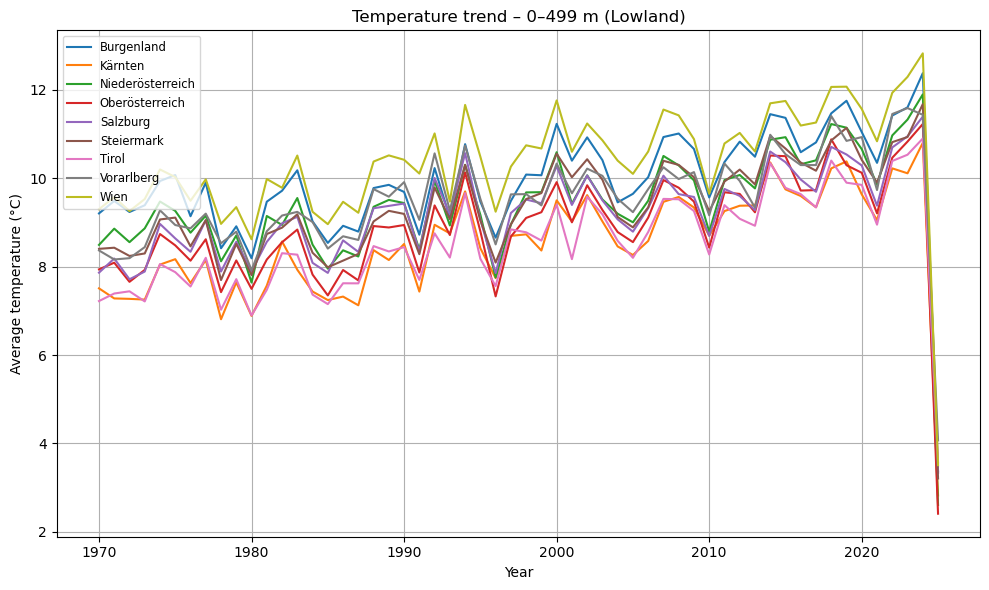

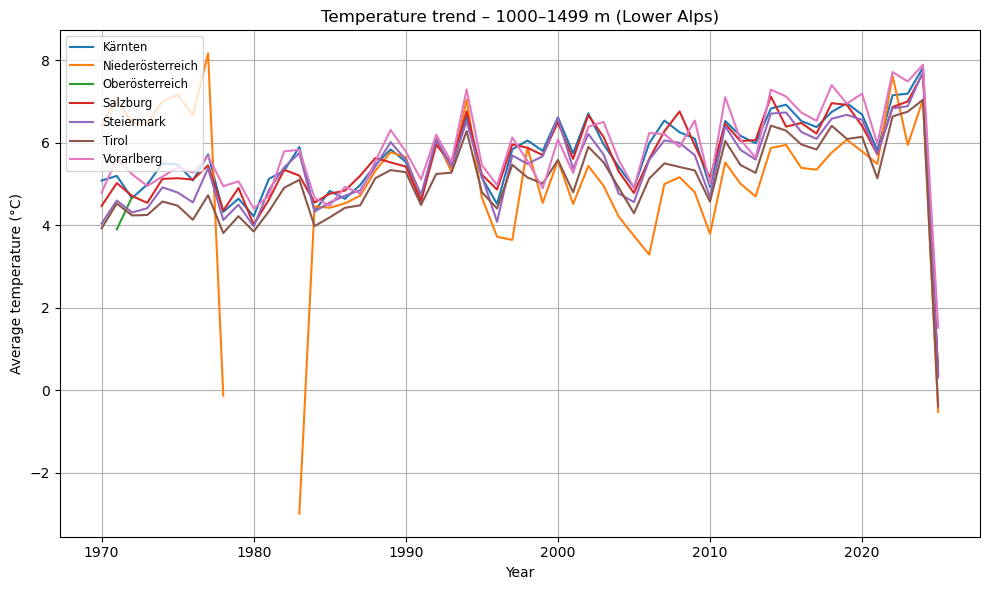

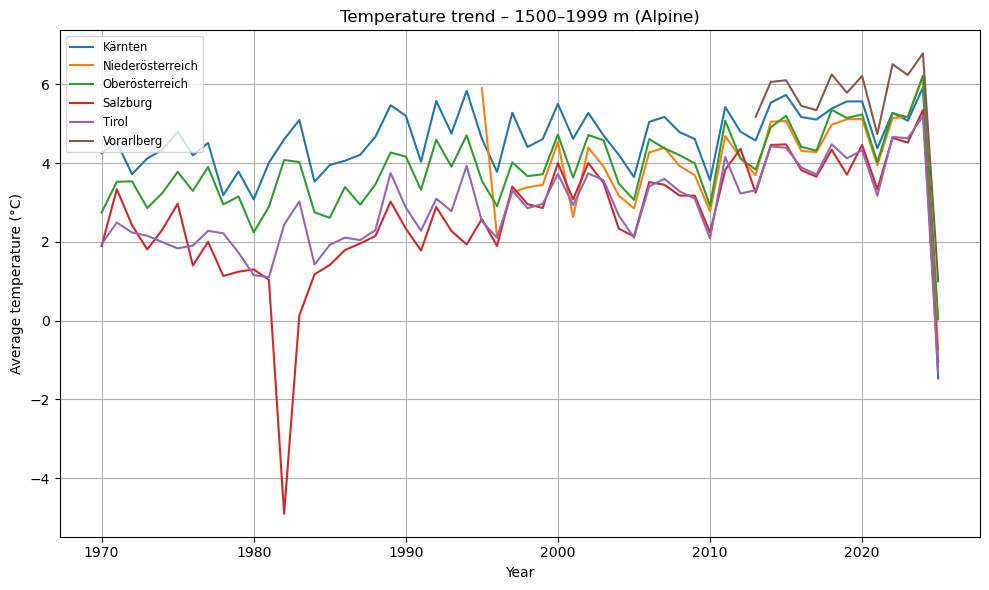

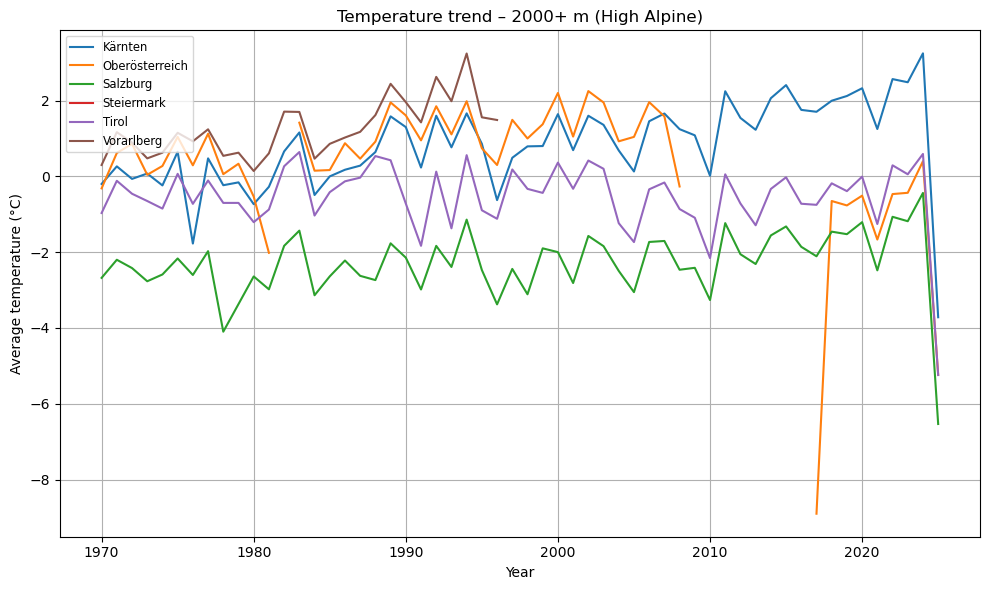

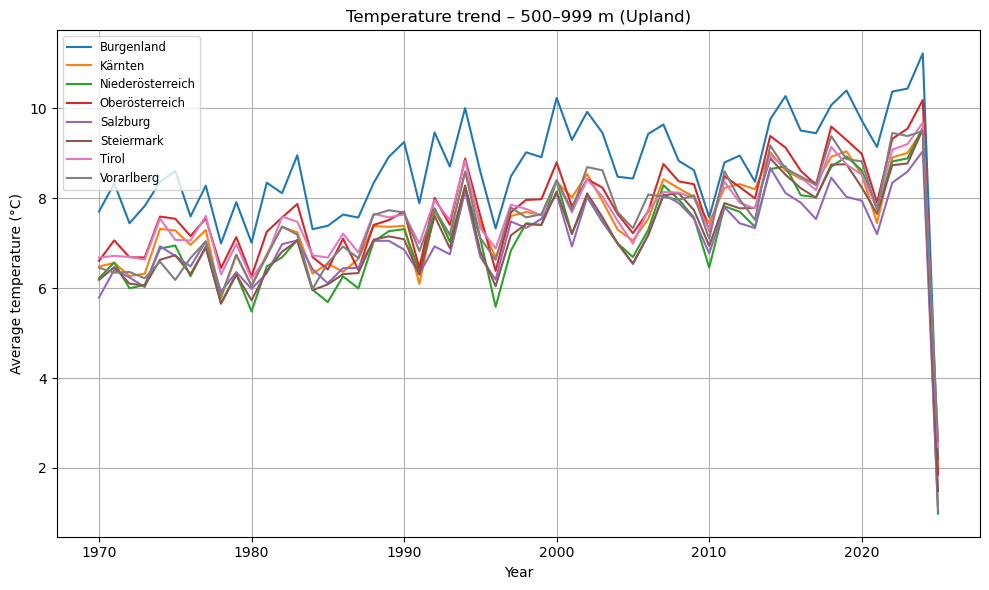

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

df_pd = df_avg.toPandas()

df_pd["year"] = df_pd["year"].astype(int)

zones = df_pd["elevation_zone"].unique()

for zone in sorted(zones):
    plt.figure(figsize=(10, 6))
    subset = df_pd[df_pd["elevation_zone"] == zone]

    for bundesland in subset["bundesland"].unique():
        region_data = subset[subset["bundesland"] == bundesland]
        plt.plot(region_data["year"], region_data["mean_temp"], label=bundesland)

    plt.title(f"Temperature trend – {zone}")
    plt.xlabel("Year")
    plt.ylabel("Average temperature (°C)")
    plt.legend(loc="upper left", fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Station Count and Altitude Statistics per Zone

In [12]:
from pyspark.sql.functions import when

stations_meta_zones = stations_meta.withColumn(
    "elevation_zone",
    when(col("altitude") < 500, "0–499 m (Lowland)")
    .when(col("altitude") < 1000, "500–999 m (Upland)")
    .when(col("altitude") < 1500, "1000–1499 m (Lower Alps)")
    .when(col("altitude") < 2000, "1500–1999 m (Alpine)")
    .otherwise("2000+ m (High Alpine)")
)


In [13]:
from pyspark.sql.functions import count, avg, min, max

station_stats = stations_meta_zones.groupBy("elevation_zone", "bundesland") \
    .agg(
        count("*").alias("num_stations"),
        avg("altitude").alias("avg_altitude"),
        min("altitude").alias("min_altitude"),
        max("altitude").alias("max_altitude")
    ) \
    .orderBy("elevation_zone", "bundesland")

station_stats.show(truncate=False)


+------------------------+----------------+------------+------------------+------------+------------+
|elevation_zone          |bundesland      |num_stations|avg_altitude      |min_altitude|max_altitude|
+------------------------+----------------+------------+------------------+------------+------------+
|0–499 m (Lowland)       |Burgenland      |51          |219.6705882352941 |116.0       |444.0       |
|0–499 m (Lowland)       |Kärnten         |49          |456.1938775510204 |384.0       |495.0       |
|0–499 m (Lowland)       |Niederösterreich|178         |271.8129213483146 |143.5       |499.0       |
|0–499 m (Lowland)       |Oberösterreich  |83          |393.20120481927705|257.0       |496.0       |
|0–499 m (Lowland)       |Salzburg        |9           |433.43333333333334|419.0       |489.9       |
|0–499 m (Lowland)       |Steiermark      |43          |353.5674418604651 |207.0       |492.0       |
|0–499 m (Lowland)       |Tirol           |6           |490.3333333333333 |474.0  

## Plot Station Distribution

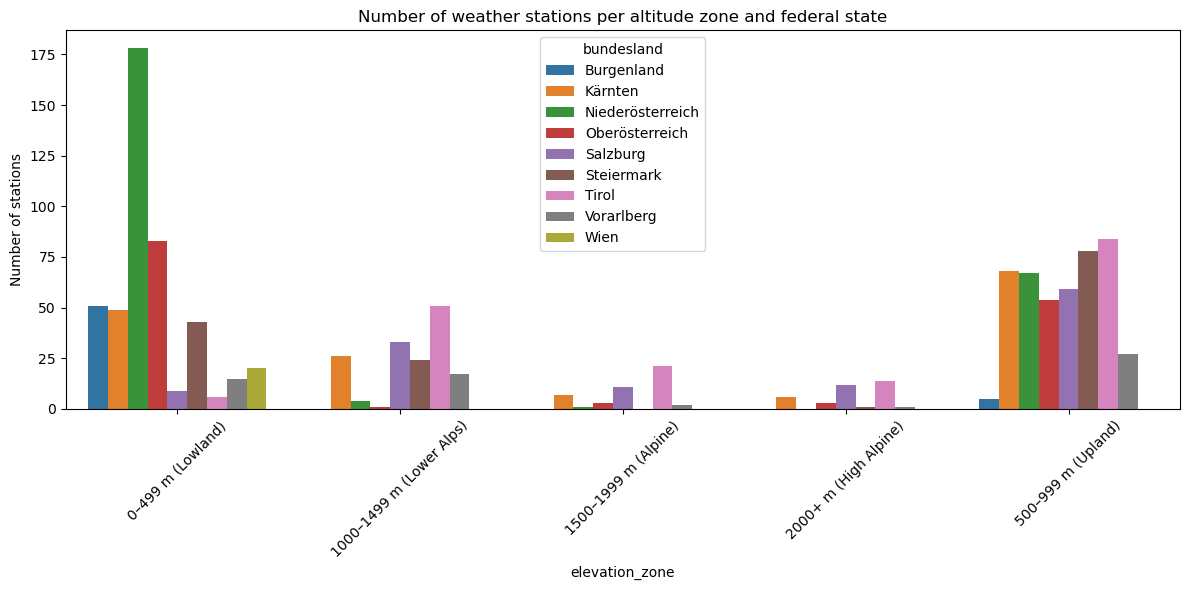

In [14]:
pd_stats = station_stats.toPandas()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=pd_stats, x="elevation_zone", y="num_stations", hue="bundesland")
plt.title("Number of weather stations per altitude zone and federal state")
plt.ylabel("Number of stations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Highlighting the Highest Stations per Region in Alpine Zones

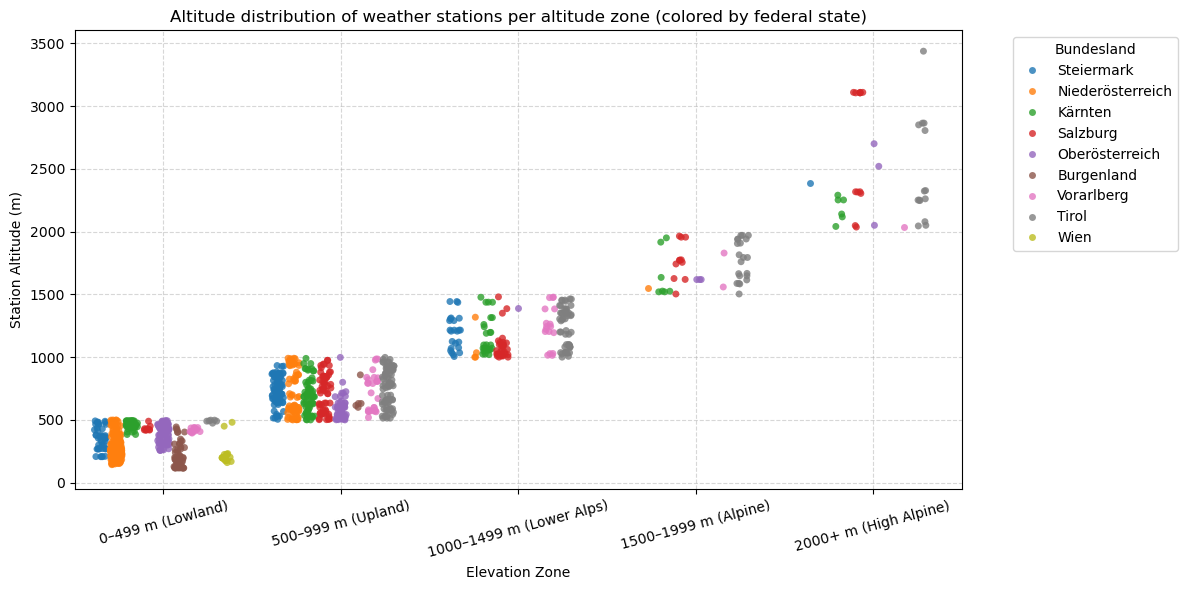

In [15]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns

stations_pd = stations_meta_zones.select(
    "station_id", "altitude", "elevation_zone", "bundesland", "Stationsname"
).toPandas()


zone_order = [
    "0–499 m (Lowland)",
    "500–999 m (Upland)",
    "1000–1499 m (Lower Alps)",
    "1500–1999 m (Alpine)",
    "2000+ m (High Alpine)"
]

stations_pd["elevation_zone"] = stations_pd["elevation_zone"].astype(
    CategoricalDtype(categories=zone_order, ordered=True)
)

plt.figure(figsize=(12, 6))
sns.stripplot(
    data=stations_pd,
    x="elevation_zone",
    y="altitude",
    hue="bundesland",
    dodge=True,
    jitter=0.3,
    alpha=0.8,
    marker="o"
)

plt.title("Altitude distribution of weather stations per altitude zone (colored by federal state)")
plt.xlabel("Elevation Zone")
plt.ylabel("Station Altitude (m)")
plt.xticks(rotation=15)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Bundesland", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [16]:
# Filter only Alpine zones
zone_order = ["1500–1999 m (Alpine)", "2000+ m (High Alpine)"]

stations_pd["elevation_zone"] = stations_pd["elevation_zone"].astype(
    CategoricalDtype(categories=zone_order, ordered=True)
)

stations_subset = stations_pd[stations_pd["elevation_zone"].isin(zone_order)].copy()

top_stations = (
    stations_subset[stations_subset["altitude"].notna()]
    .sort_values("altitude", ascending=False)
    .groupby(["elevation_zone", "bundesland"], as_index=False)
    .first()
)

top_stations


,elevation_zone,bundesland,station_id,altitude,Stationsname
0,1500–1999 m (Alpine),Kärnten,15360.0,1950.0,Palik
1,1500–1999 m (Alpine),Niederösterreich,10412.0,1547.2,Rax Seilbahnbergstation
2,1500–1999 m (Alpine),Oberösterreich,205.0,1618.0,Feuerkogel
3,1500–1999 m (Alpine),Salzburg,12310.0,1964.0,Schmittenhöhe
4,1500–1999 m (Alpine),Steiermark,NaN,NaN,NaN
5,1500–1999 m (Alpine),Tirol,12205.0,1970.0,Kitzbühler Horn
6,1500–1999 m (Alpine),Vorarlberg,17010.0,1829.0,Kops
7,2000+ m (High Alpine),Kärnten,18241.0,2290.0,Reisseckhütte
8,2000+ m (High Alpine),Niederösterreich,NaN,NaN,NaN
9,2000+ m (High Alpine),Oberösterreich,12720.0,2700.0,Dachstein-Hunerkogel


In [17]:
print(stations_pd.columns)


Index(['station_id', 'altitude', 'elevation_zone', 'bundesland',
       'Stationsname'],
      dtype='object')


## Plot Top Alpine Stations

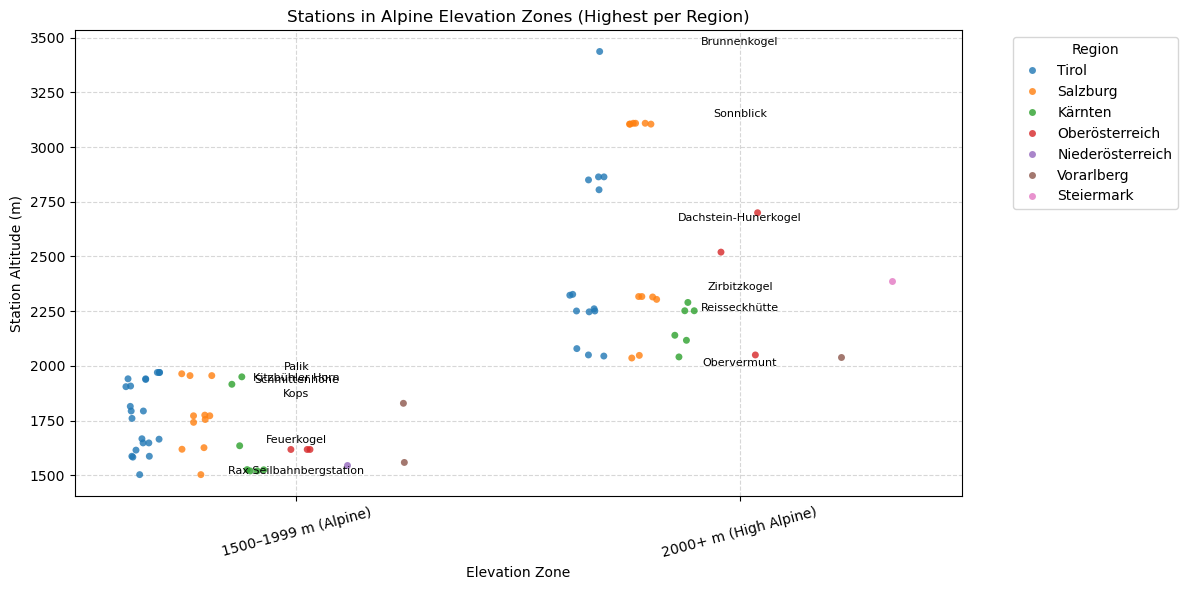

In [18]:
stations_name_pd = stations_meta.select("station_id", "Stationsname").toPandas()
top_stations = top_stations.drop(columns=["Stationsname"], errors="ignore")
top_stations = top_stations.merge(stations_name_pd, on="station_id", how="left")

top_stations_clean = top_stations.dropna(subset=["elevation_zone", "altitude", "Stationsname"])

plt.figure(figsize=(12, 6))

sns.stripplot(
    data=stations_subset,
    x="elevation_zone",
    y="altitude",
    hue="bundesland",
    jitter=0.3,
    dodge=True,
    alpha=0.8,
    marker="o"
)

for i, row in top_stations_clean.iterrows():
    offset = 30 if i % 2 == 0 else -40
    plt.text(
        x=row["elevation_zone"],
        y=row["altitude"] + offset,
        s=row["Stationsname"],
        ha="center",
        fontsize=8,
        color="black"
    )

plt.title("Stations in Alpine Elevation Zones (Highest per Region)")
plt.xlabel("Elevation Zone")
plt.ylabel("Station Altitude (m)")
plt.xticks(rotation=15)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Region")
plt.tight_layout()
plt.show()